In [1]:
import pandas as pd
import os
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from fastdtw import fastdtw

from timewheel import pie_heatmap_df, pie_heatmap
os.chdir(os.path.dirname(os.getcwd()))
print(os.getcwd())


/home/congyu/congyu_program/pythons/inits/k_data_analysis_tools


In [2]:
PATH_TO_DB = "./datasets/covid"
PATH_TO_DATA = os.path.join(PATH_TO_DB, "covid_de.csv")

DATE = "date"
CASES = "cases"
DAYS_AFTER = "days_after"
DATETIME = "datetime"
PERIOD_ID = "period_id"
PERIOD_ID_DAY = "period_id_day"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376608 entries, 0 to 376607
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   state      376608 non-null  object
 1   county     376608 non-null  object
 2   age_group  374005 non-null  object
 3   gender     368898 non-null  object
 4   date       376608 non-null  object
 5   cases      376608 non-null  int64 
 6   deaths     376608 non-null  int64 
 7   recovered  376608 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 23.0+ MB
None
                state              county age_group gender        date  cases  \
0  Baden-Wuerttemberg  LK Alb-Donau-Kreis     00-04      F  2020-03-27      1   
1  Baden-Wuerttemberg  LK Alb-Donau-Kreis     00-04      F  2020-03-28      1   
2  Baden-Wuerttemberg  LK Alb-Donau-Kreis     00-04      F  2020-04-03      1   
3  Baden-Wuerttemberg  LK Alb-Donau-Kreis     00-04      F  2020-10-18      1   
4  Baden-Wuerttemberg  LK Alb

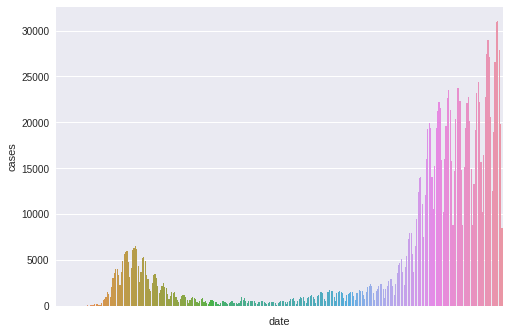

In [30]:
df = pd.read_csv(PATH_TO_DATA)
print(df.info())
print(df.head())

df_date = df.groupby(DATE)[CASES].apply(sum)
df_date = df_date.reset_index()

fig, ax = plt.subplots()
sns.barplot(x=DATE, y=CASES, data=df_date)
ax.set_xticklabels([])
# plt.xticklabels = None
# todo: filter by start_date

df_date[DATETIME] = df_date[DATE].apply(lambda date_obj: datetime.strptime(str(date_obj), "%Y-%m-%d"))
df_date = df_date.sort_values(DATETIME)
df_date[DAYS_AFTER] = df_date[DATETIME] - pd.to_datetime([df_date[DATETIME][0] for _ in range(len(df_date))])
df_date[DAYS_AFTER] = df_date[DAYS_AFTER].dt.days
print(df_date.head())


period_id       0    1    2   3    4    5    6    7     8      9   ...  \
period_id_day                                                      ...   
0              1.0  NaN  NaN NaN  1.0  1.0  NaN  1.0  24.0  184.0  ...   
1              NaN  NaN  NaN NaN  6.0  1.0  NaN  NaN  48.0  186.0  ...   
2              NaN  NaN  1.0 NaN  NaN  NaN  1.0  NaN  22.0  141.0  ...   
3              NaN  1.0  NaN NaN  NaN  NaN  NaN  NaN  36.0  102.0  ...   
4              NaN  NaN  NaN NaN  1.0  NaN  2.0  1.0  41.0  347.0  ...   

period_id          41       42       43       44       45       46       47  \
period_id_day                                                                 
0              7894.0  13877.0  19873.0  22254.0  23503.0  23716.0  22806.0   
1              7970.0  14048.0  19431.0  21593.0  21373.0  22328.0  20120.0   
2              5693.0  11104.0  14031.0  15899.0  15781.0  14801.0  14930.0   
3              3682.0   7485.0  10546.0  10192.0   8836.0   8853.0   8823.0   
4      

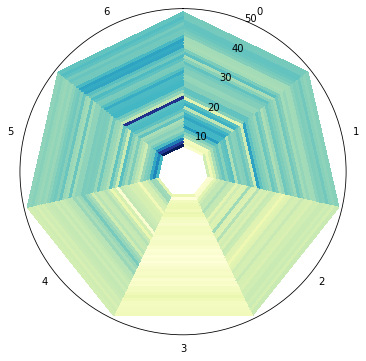

In [4]:
period = 7
df_date[PERIOD_ID] = [day//period for day in df_date[DAYS_AFTER]]
df_date[PERIOD_ID_DAY] = [day % period for day in df_date[DAYS_AFTER]]

# plot the charts
df_timewheel = df_date.pivot_table(values=CASES, index=[PERIOD_ID_DAY], columns=[PERIOD_ID], aggfunc='sum')
print(df_timewheel.head())

# pie_heatmap_df(df_timewheel)

data = np.array(df_timewheel.values)
data /= np.sum(data, axis=0)[np.newaxis, :]
pie_heatmap(data, df_timewheel.index, None)
# todo: plot xlabels with jump

# calculate the dist_metric
df_timewheel_t = df_date.pivot_table(values=CASES, index=[PERIOD_ID], columns=[PERIOD_ID_DAY], aggfunc='sum')
df_timewheel_t = df_timewheel_t.dropna()
data_t = np.array(df_timewheel_t.values)
data_t /= np.sum(data_t, axis=1)[:, np.newaxis]

dist_matrix = np.zeros((data_t.shape[0], data_t.shape[0]))
for i in range(data_t.shape[0]):
    for j in range(data_t.shape[0]):
        dist, _ = fastdtw(data_t[i, :], data_t[j, :])
        dist_matrix[i, j] = dist
# print(dist_matrix)
dist_metric = np.median(dist_matrix)

period_id       0    1      2       3       4      5      6      7       8   \
period_id_day                                                                 
0              1.0  NaN   41.0  6265.0   918.0  179.0  460.0  855.0   831.0   
1              NaN  NaN   85.0  6553.0   622.0  137.0  484.0  920.0   537.0   
2              NaN  1.0  154.0  6192.0   427.0  305.0  470.0  561.0  1185.0   
3              NaN  4.0  184.0  4337.0   724.0  498.0  426.0  301.0  1317.0   
4              NaN  NaN  186.0  2553.0  1092.0  528.0  293.0  796.0  1410.0   

period_id          9        10       11  
period_id_day                            
0              1820.0  19280.0  20120.0  
1              2166.0  19873.0  14930.0  
2              2735.0  19431.0   8823.0  
3              2912.0  14031.0  13324.0  
4              2917.0  10546.0  19192.0  


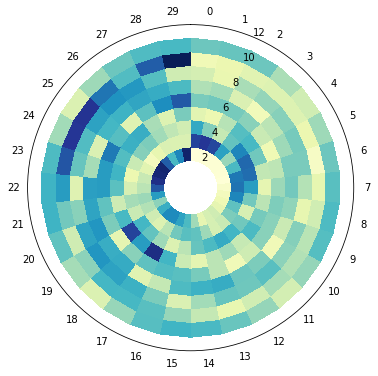

In [5]:
period = 30
df_date[PERIOD_ID] = [day//period for day in df_date[DAYS_AFTER]]
df_date[PERIOD_ID_DAY] = [day % period for day in df_date[DAYS_AFTER]]

# plot the charts
df_timewheel = df_date.pivot_table(values=CASES, index=[PERIOD_ID_DAY], columns=[PERIOD_ID], aggfunc='sum')
print(df_timewheel.head())

# pie_heatmap_df(df_timewheel)

data = np.array(df_timewheel.values)
data /= np.sum(data, axis=0)[np.newaxis, :]
pie_heatmap(data, df_timewheel.index, None)
# todo: plot xlabels with jump

# calculate the dist_metric
df_timewheel_t = df_date.pivot_table(values=CASES, index=[PERIOD_ID], columns=[PERIOD_ID_DAY], aggfunc='sum')
df_timewheel_t = df_timewheel_t.dropna()
data_t = np.array(df_timewheel_t.values)
data_t /= np.sum(data_t, axis=1)[:, np.newaxis]

dist_matrix = np.zeros((data_t.shape[0], data_t.shape[0]))
for i in range(data_t.shape[0]):
    for j in range(data_t.shape[0]):
        dist, _ = fastdtw(data_t[i, :], data_t[j, :])
        dist_matrix[i, j] = dist
# print(dist_matrix)
dist_metric = np.median(dist_matrix)

In [6]:
def calc_dist_metric(df_date, period):
    df_date[PERIOD_ID] = [day//period for day in df_date[DAYS_AFTER]]
    df_date[PERIOD_ID_DAY] = [day % period for day in df_date[DAYS_AFTER]]

    # calculate the dist_metric
    df_timewheel_t = df_date.pivot_table(values=CASES, index=[PERIOD_ID], columns=[PERIOD_ID_DAY], aggfunc='sum')
    df_timewheel_t = df_timewheel_t.dropna()
    data_t = np.array(df_timewheel_t.values)
    data_t /= np.sum(data_t, axis=1)[:, np.newaxis]

    dist_matrix = np.zeros((data_t.shape[0], data_t.shape[0]))
    for i in range(data_t.shape[0]):
        for j in range(data_t.shape[0]):
            dist, _ = fastdtw(data_t[i, :], data_t[j, :])
            dist_matrix[i, j] = dist

    # print(dist_matrix)
    dist_metric = np.median(dist_matrix)

    return dist_metric


In [13]:
plt.style.use('seaborn')

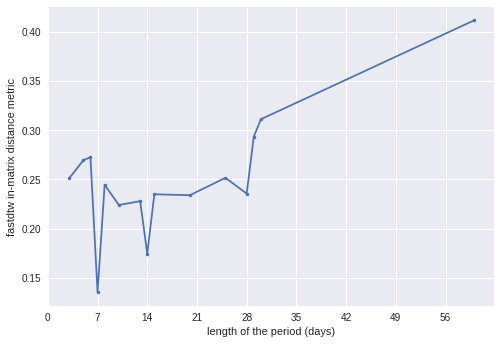

In [24]:
periods = [3, 5, 6, 7, 8, 10, 13, 14, 15, 20, 25, 28, 29, 30, 60]
metrics = [calc_dist_metric(df_date, period) for period in periods]

plt.plot(periods, metrics, ".-")
plt.xticks(np.arange(0, max(periods)+1, 7))
plt.xlabel("length of the period (days)")
plt.ylabel("fastdtw in-matrix distance metric")
plt.show()